In [1]:
import numpy as np
import time
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

In [265]:
def oprod(T):
    out=T[0]
    for i in range(1,len(T)):
        out=np.multiply.outer(out,T[i])
    return out
def ID(N,d):
    out=np.zeros((N,)*d,dtype=int)
    for i in range(N):
        out[(i,)*A]=1
    return out
def readmat(info,vals=(lambda c:-1 if c=='n' else ord(c)-ord('0'))):
    return np.array(list(map(
        lambda rowstr:list(map(vals,list(rowstr))),
        info.split('.'))))
def mmT(N):
    T=np.zeros((N,)*6,dtype=int)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                T[i][j][j][k][k][i]=1
    return T
def compress(T):
    S=T.shape
    assert len(S)%2==0, 'odd-dimensional tensor'
    nS=[]
    for i in range(0,len(S),2):
        nS.append(S[i]*S[i+1])
    return T.reshape(tuple(nS))
def sumdecomp(decomp):
    return sum(map(oprod,decomp))
def plotT(ax,T,cmapname='bwr',ptsize=100,**kwargs):
    data=np.array(np.where(T!=0))
    vals=np.array(list(map(lambda pt:T[tuple(pt)],np.transpose(data))))
    if len(vals)==0:
        return None
    ax.scatter(*data,c=list(map(lambda v:plt.get_cmap(cmapname)(int(v)),128*vals+128)),s=ptsize,**kwargs)

In [17]:
class SparseTensor: #data structure for storing sparse tensors
    def __init__(self,shape,pts={}):
        assert isinstance(shape,tuple), 'shape is not a tuple'
        self.shape=shape
        for pt in pts:
            assert len(pt)==len(self.shape), 'incorrect dimension # for pt'
            for d in range(len(self.shape)):
                assert 0<=pt[d] and pt[d]<self.shape[d], 'pt '+str(pt)+'out of bounds '+str(self.shape)
                assert not(isinstance(pt[d],float)), 'non-integer index: '+str(pt)+' (type='+str(type(pt[d]))+')'
        self.pts=dict(pts)
        #^^^ simply saying self.pts causes a strange bug where all-0 matrices are incorrectly initialized
    def iszero(self):
        for k in self.pts:
            if self.pts[k]!=0:
                return False
        return True
    def toarr(self):
        out=np.zeros(self.shape)
        for k in self.pts:
            out[k]=self.pts[k]
        return out
    def __str__(self):
        return str(self.shape)+': '+str(self.pts)
    def __neg__(self):
        return self*(-1)
    def __add__(self,o):
        if isinstance(o,SparseTensor): #element-wise sum
            assert self.shape==o.shape, 'adding two SpraseTensors with different shapes'
            out=SparseTensor(self.shape)
            pts=set((*list(self.pts.keys()),*list(o.pts.keys())))
            for k in pts:
                v=(self.pts[k] if k in self.pts else 0)+(o.pts[k] if k in o.pts else 0)
                if v!=0:
                    out.pts[k]=v
            return out
        else:
            return SparseTensor(self.shape,{k:o+self.pts[k] for k in self.pts})
    def __sub__(self,o):
        return self+(-o)
    def __radd__(self,o):
        return self+o
    def __mul__(self,o):
        if isinstance(o,SparseTensor): #outer product
            out=SparseTensor(self.shape+o.shape)
            for k in self.pts:
                for m in o.pts:
                    v=self.pts[k]*o.pts[m]
                    assert v!=0, '0 element marked in dictionary'
                    out.pts[k+m]=v
            return out
        else:
            return SparseTensor(self.shape,{k:o*self.pts[k] for k in self.pts})
        raise 'multiplying a SparseTensor by something other than a scalar or SparseTensor'
    def __rmul__(self,o):
        return self*o
scale=lambda s,mats:(mats[0]*s,)+tuple(mats[1:])

rank(mmT(10))<=1200
creation time=0.13263916969299316
summing time=2.6427090167999268
False
checking time=0.005836009979248047


<IPython.core.display.Javascript object>


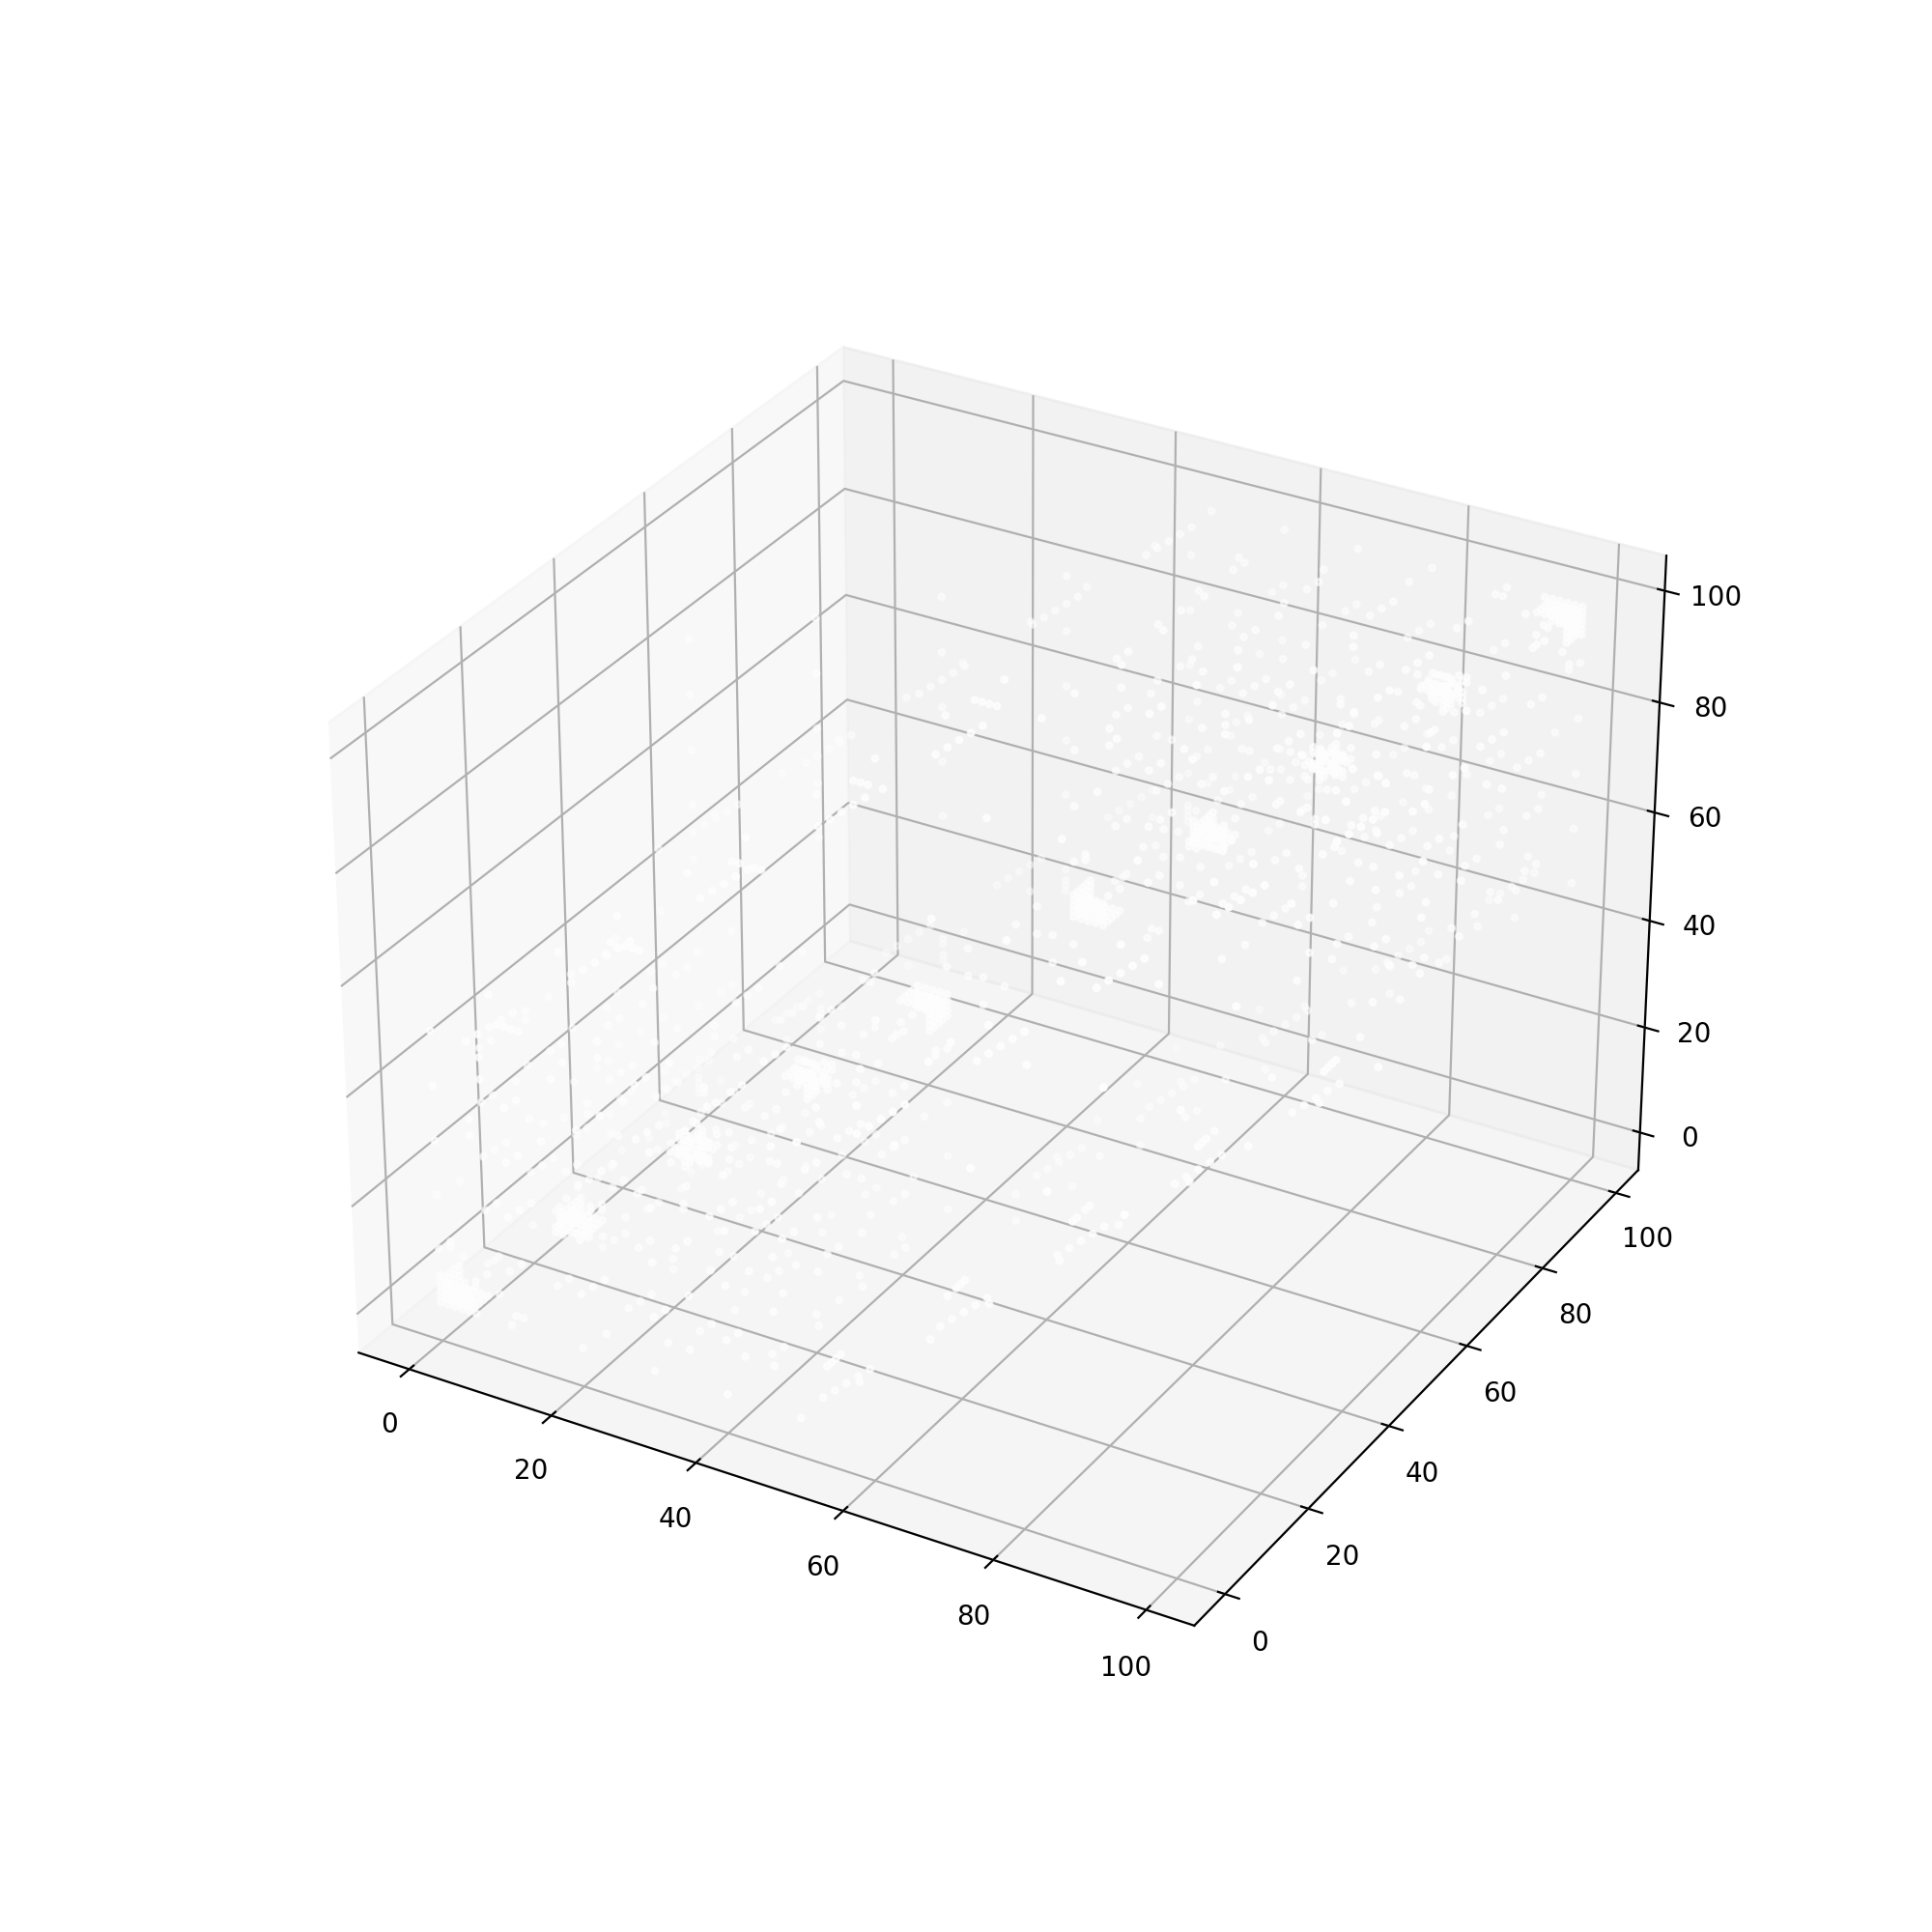

graphing time=0.06712722778320312
bad vals={-8.881784197001252e-16, -4.440892098500626e-16, -1.1102230246251565e-16, 0.0, 1.1102230246251565e-16, 3.3306690738754696e-16, 6.661338147750939e-16, 8.881784197001252e-16, 4.440892098500626e-16, -6.661338147750939e-16, -5.551115123125783e-16}


In [268]:
st=time.time()
#better trilinear aggregation based on Laderman, Pan, Sha
#computes 2Nx2N matrix multiplication using 8/3*N^3+16*N^2+O(N) multiplications
#    instead of 8/3*N^3+24*N^2+O(N)
N=5
N2=set([(i,j) for i in range(N) for j in range(N)])
N3=set([(i,j,k) for i in range(N) for j in range(N) for k in range(N)])
def med_decomp(A,B):
    #A,B are 3xNxN arrays of arbitrary tensors
    #we want to compute
    #sum_{ijk; i,j,k not all the same number} (
    #    1/2*A0ij*A1ij*A2ij + 1/2*B0ki*B1ki*B2ki)
    #    A0ij*A1ij*B2ki + A0ij*B1ki*A2ij + B0ki*A1ij*A2ij
    #  + B0ki*B1ki*A2ij + B0ki*A1ij*B2ki + B0ki*B1ki*A2ij)
    decomp=[]
#     for i,j,k in N3:
#         decomp.extend([
#             scale(1/2,(A[0][i][j],A[1][i][j],A[2][i][j])),
#             scale(1/2,(B[0][i][j],B[1][i][j],B[2][i][j])),
#             (A[0][i][j],A[1][i][j],B[2][k][i]),
#             (A[0][i][j],B[1][k][i],A[2][i][j]),
#             (B[0][k][i],A[1][i][j],A[2][i][j]),
#             (B[0][k][i],B[1][k][i],A[2][i][j]),
#             (B[0][k][i],A[1][i][j],B[2][k][i]),
#             (A[0][i][j],B[1][k][i],B[2][k][i]),
#         ])

    J=[[sum([A[a][i][j] for j in range(N)]) for i in range(N)] for a in range(3)]
    K=[[sum([B[a][k][i] for k in range(N)]) for i in range(N)] for a in range(3)]
    #TODO: REDUCE RANK OF THIS BIT
#     for i,j in N2:
#         decomp.extend([
#             scale(N/2,(A[0][i][j],A[1][i][j],A[2][i][j])),
#             scale(N/2,(B[0][i][j],B[1][i][j],B[2][i][j])),
#         ])
#     for i,j in N2:
#         decomp.extend([
#             (A[0][i][j],A[1][i][j],K[2][i]),
#             (A[0][i][j],K[1][i],A[2][i][j]),
#             (K[0][i],A[1][i][j],A[2][i][j]),
#         ])
#     for k,i in N2:
#         decomp.extend([
#             (B[0][k][i],B[1][k][i],J[2][i]),
#             (B[0][k][i],J[1][i],B[2][k][i]),
#             (J[0][i],B[1][k][i],B[2][k][i]),
#         ])

    for i,j in N2:
        decomp.append(scale(1/(2*N*N),tuple((N*A[a][i][j]+2*K[a][i] for a in range(3)))))
    for k,i in N2:
        decomp.append(scale(1/(2*N*N),tuple((N*B[a][k][i]+2*J[a][i] for a in range(3)))))
    s=-4*N/(2*N*N)
    for i in range(N):
        decomp.extend([
            scale(s,tuple((J[a][i] for a in range(3)))),
            scale(s,tuple((K[a][i] for a in range(3)))),
            scale(s,tuple((J[a][i]+K[a][i] for a in range(3))))
        ])
    for i in range(N):
        decomp.extend([
            scale(-1/2,(A[0][i][i],A[1][i][i],A[2][i][i])),
            scale(-1/2,(B[0][i][i],B[1][i][i],B[2][i][i])),
            (-A[0][i][i],A[1][i][i],B[2][i][i]),
            (-A[0][i][i],B[1][i][i],A[2][i][i]),
            (-B[0][i][i],A[1][i][i],A[2][i][i]),
            (-B[0][i][i],B[1][i][i],A[2][i][i]),
            (-B[0][i][i],A[1][i][i],B[2][i][i]),
            (-A[0][i][i],B[1][i][i],B[2][i][i]),
        ])
    return decomp
E=lambda i,j:np.array([[1 if r==i and c==j else 0 for c in range(2*N)] for r in range(2*N)])
decomp=[(E(i+a*N,i+b*N),E(i+b*N,i+c*N),E(i+c*N,i+a*N)) for i in range(N) for a in range(2) for b in range(2) for c in range(2)]
S=set()
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i<j and i<k and j!=k) or (j==k and i!=j):
                S.add((i,j,k))
for i,j,k in S:
    decomp.extend([
        (E(i,j)+E(j,k)+E(k,i),)*3,
        (-E(i,j)+E(j+N,k)+E(k,i+N),E(j,k+N)+E(k,i)+E(i+N,j),-E(k+N,i)+E(i,j+N)+E(j,k)),
        (E(i,j+N)-E(j,k)+E(k+N,i),E(j+N,k)+E(k,i+N)+E(i,j),E(k,i)-E(i+N,j)+E(j,k+N)),
        (E(i+N,j)+E(j,k+N)-E(k,i),E(j,k)+E(k+N,i)+E(i,j+N),E(k,i+N)+E(i,j)-E(j+N,k)),
        (E(i+N,j+N)+E(j+N,k+N)+E(k+N,i+N),)*3,
        (-E(i+N,j+N)+E(j,k+N)+E(k+N,i),E(j+N,k)+E(k+N,i+N)+E(i,j+N),-E(k,i+N)+E(i+N,j)+E(j+N,k+N)),
        (E(i+N,j)-E(j+N,k+N)+E(k,i+N),E(j,k+N)+E(k+N,i)+E(i+N,j+N),E(k+N,i+N)-E(i,j+N)+E(j+N,k)),
        (E(i,j+N)+E(j+N,k)-E(k+N,i+N),E(j+N,k+N)+E(k,i+N)+E(i+N,j),E(k+N,i)+E(i+N,j+N)-E(j,k+N)),
    ])
matmat=lambda sig:[[sig[0][0]*E(i,j)+sig[0][1]*E(i,j+N)+sig[1][0]*E(i+N,j)+sig[1][1]*E(i+N,j+N) for j in range(N)] for i in range(N)]
A,B,C,D=map(np.array,([[1,0],[0,0]],[[0,1],[0,0]],[[0,0],[1,0]],[[0,0],[0,1]]))
decomp.extend(map(lambda mats:scale(-1,mats),[
    *med_decomp(
        (matmat(A),)*3,
        (matmat(A),)*3
    ),
    *med_decomp(
        (matmat(-A),matmat(C),matmat(B)),
        (matmat(B),matmat(A),matmat(-C)),
    ),
    *med_decomp(
        (matmat(C),matmat(B),matmat(A)),
        (matmat(-A),matmat(C),matmat(B)),
    ),
    *med_decomp(
        (matmat(B),matmat(A),matmat(-C)),
        (matmat(C),matmat(B),matmat(A)),
    ),
    *med_decomp(
        (matmat(D),)*3,
        (matmat(D),)*3
    ),
    *med_decomp(
        (matmat(-D),matmat(B),matmat(C)),
        (matmat(C),matmat(D),matmat(-B)),
    ),
    *med_decomp(
        (matmat(B),matmat(C),matmat(D)),
        (matmat(-D),matmat(B),matmat(C)),
    ),
    *med_decomp(
        (matmat(C),matmat(D),matmat(-B)),
        (matmat(B),matmat(C),matmat(D)),
    )
]))
print('rank(mmT('+str(2*N)+'))<='+str(len(decomp)))
print('creation time='+str(time.time()-st))

st=time.time()
def decompsum(D):
    out=SparseTensor((2*N,)*6)
    for row in D:
        prod=SparseTensor(tuple(),{tuple():1})
        for mat in row:
            prod*=mat
        out+=prod
    return out
retarr=sumdecomp(decomp)
print('summing time='+str(time.time()-st))

st=time.time()
def sparseMMT(n):
    pts={}
    for i in range(n):
        for j in range(n):
            for k in range(n):
                pts[(i,j,j,k,k,i)]=1
    return SparseTensor((n,)*6,pts).toarr()

T=sparseMMT(2*N)

diff=retarr-T
print(np.array_equal(retarr,T))
#print(diff.iszero())
print('checking time='+str(time.time()-st))

st=time.time()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
plotT(ax,compress(diff),ptsize=5)
print('graphing time='+str(time.time()-st))
print('bad vals='+str(set(diff.flatten())))

rank<=126
True


<IPython.core.display.Javascript object>


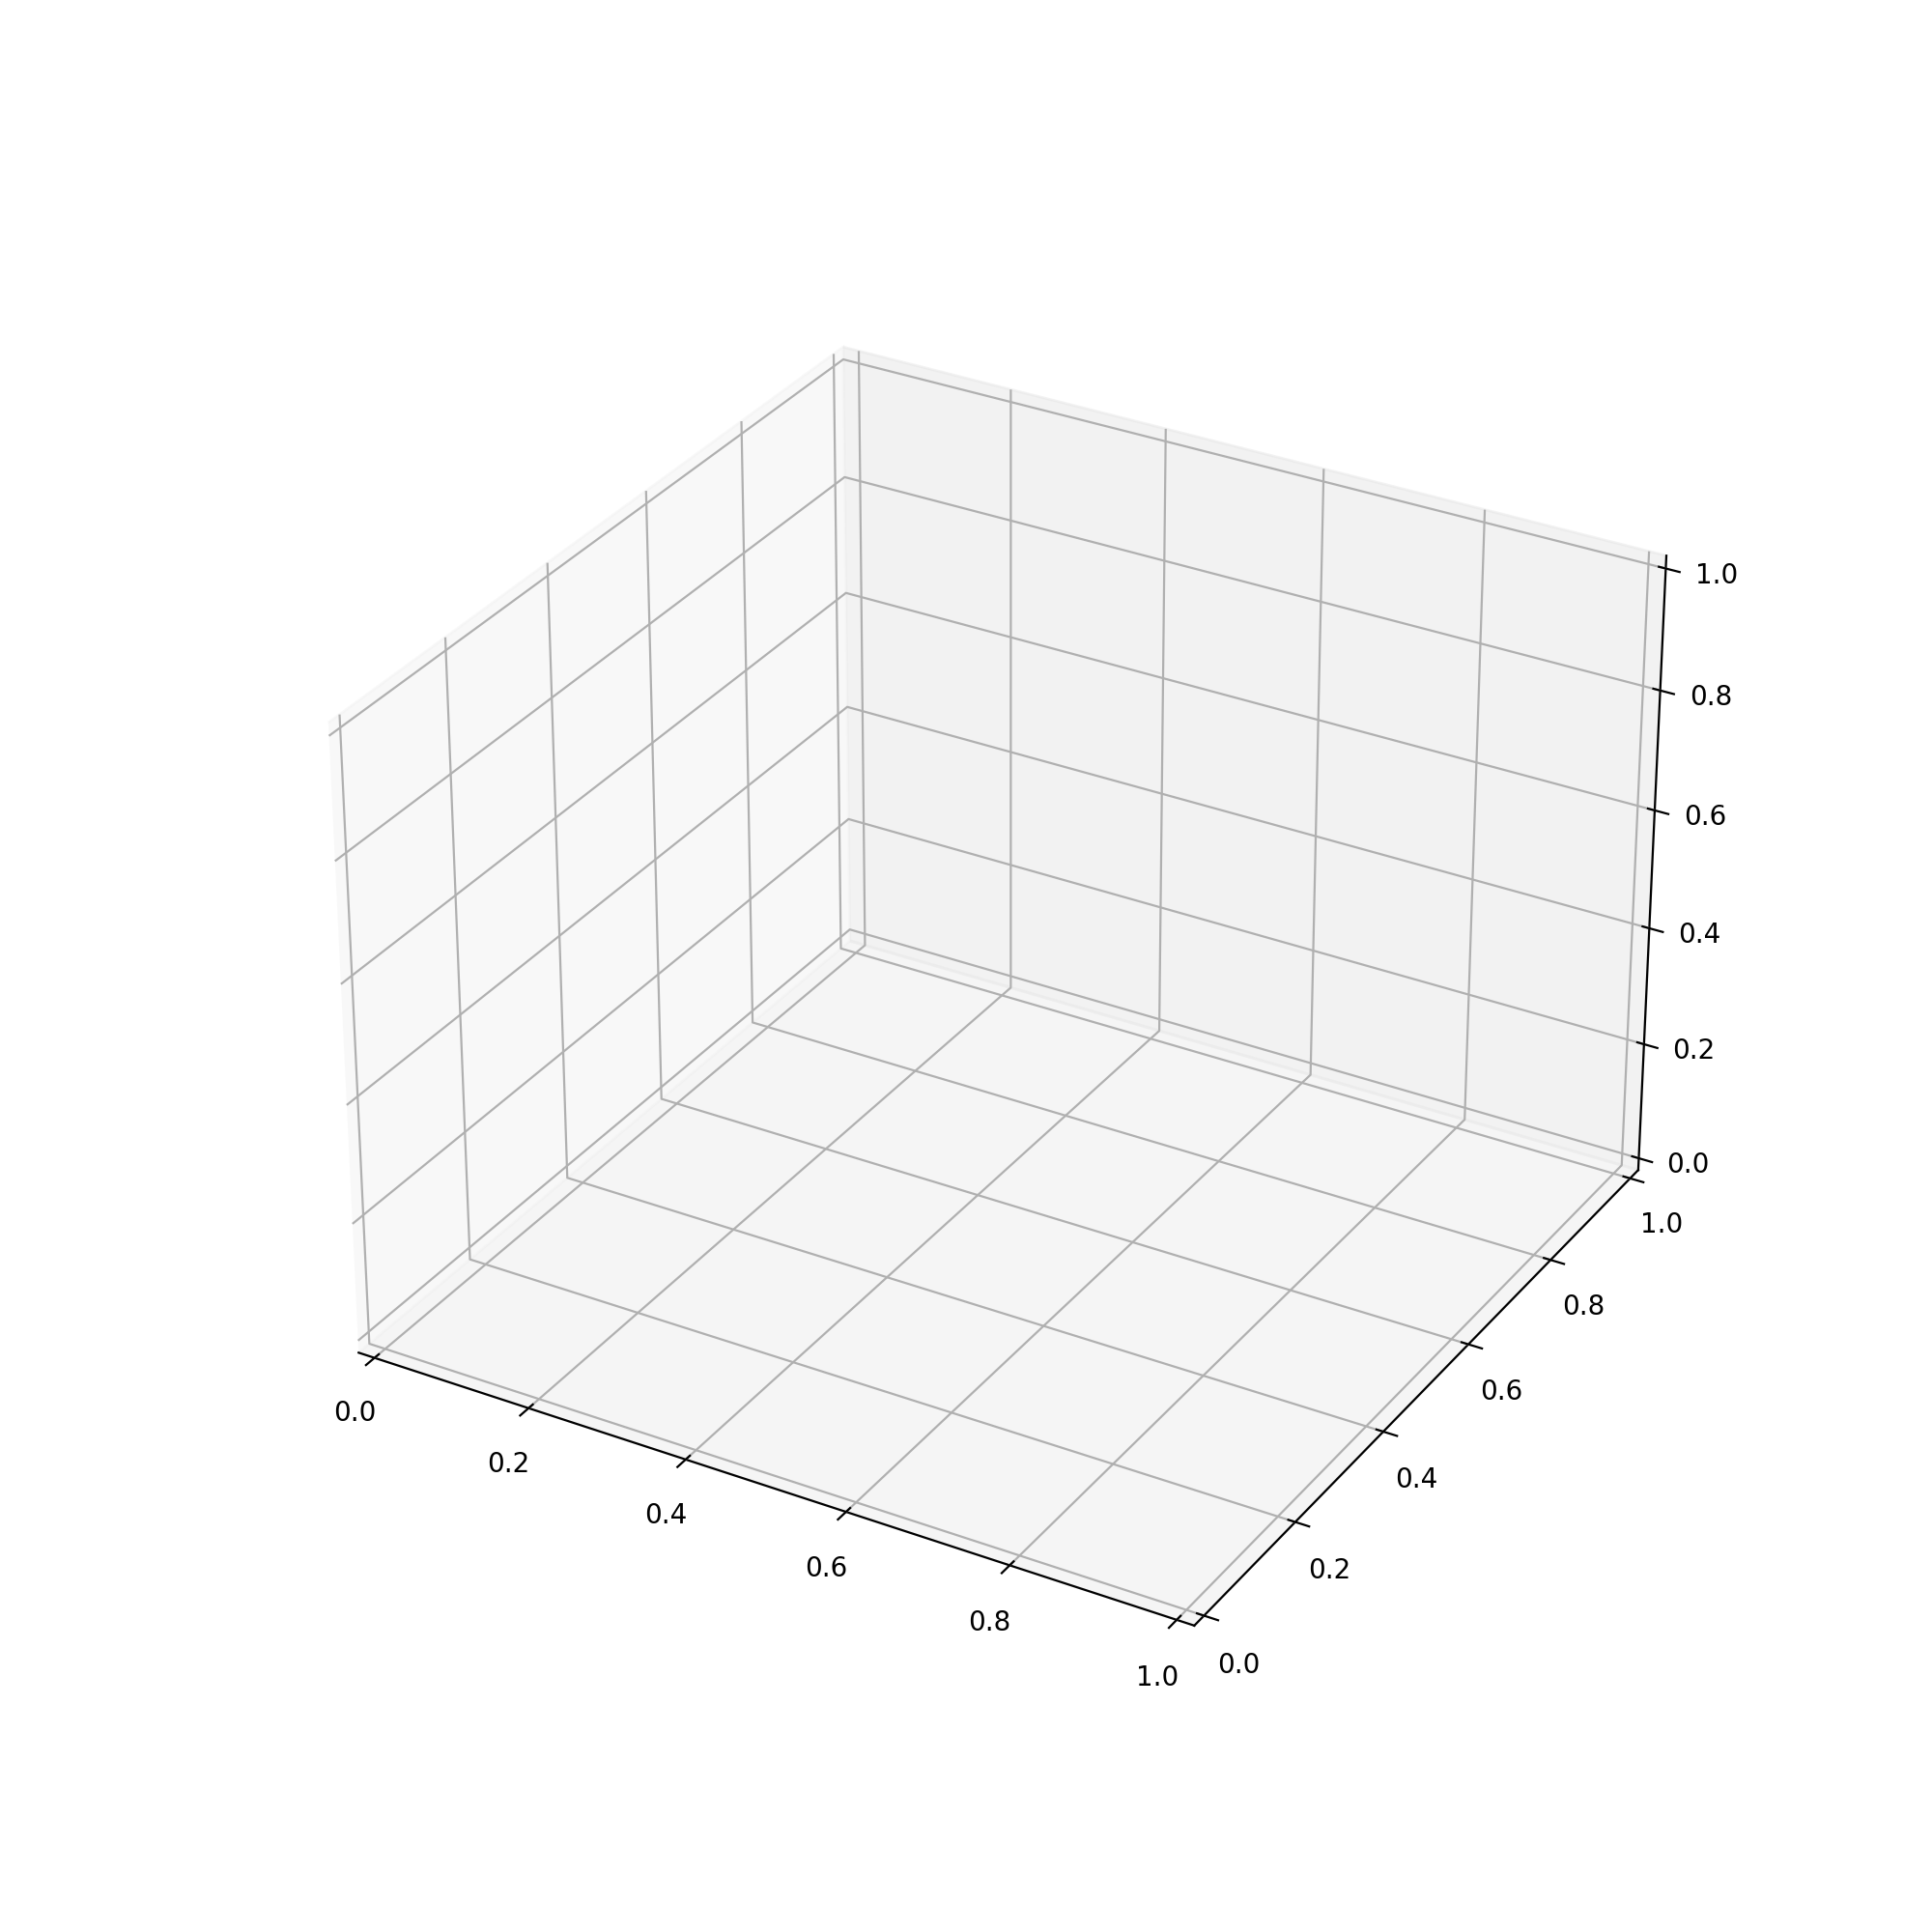

bad vals={0}


In [226]:
N=7
S=set()
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i<j and i<k and j!=k) or (j==k and i!=j):
                S.add((i,j,k))
E=lambda i,j:np.array([[1 if r==i and c==j else 0 for c in range(N)] for r in range(N)])
T=0
for i,j,k in S:
    T+=(oprod((E(i,j)+E(j,k)+E(k,i),)*3)
        -oprod((E(i,j),E(j,k),E(k,i)))
        -oprod((E(j,k),E(k,i),E(i,j)))
        -oprod((E(k,i),E(i,j),E(j,k)))
        -oprod((E(i,j),E(k,i),E(j,k)))
        -oprod((E(k,i),E(j,k),E(i,j)))
        -oprod((E(j,k),E(i,j),E(k,i))))
decomp=[]
# for i in range(N):
#     for j in range(N):
#         decomp.append(scale(N,(E(i,j),)*3))
#         for k in range(N):
#             decomp.extend([
#                 (E(i,j),E(i,j),E(k,i)),
#                 (E(i,j),E(k,i),E(i,j)),
#                 (E(k,i),E(i,j),E(i,j)),
#                 (E(k,i),E(k,i),E(i,j)),
#                 (E(k,i),E(i,j),E(k,i)),
#                 (E(i,j),E(k,i),E(k,i)),
#             ])
#     decomp.append(scale(-7,(E(i,i),)*3))

# for i in range(N):
#     J=sum([E(i,j) for j in range(N)])
#     K=sum([E(k,i) for k in range(N)])
#     for j in range(N):
#         decomp.append((E(i,j)+K,)*3)
#     for k in range(N):
#         decomp.append((E(k,i)+J,)*3)
#     decomp.extend([
#         scale(-1,(J+K,)*3),
#         scale(-(N-1),(J,)*3),
#         scale(-(N-1),(K,)*3)
#     ])
#     decomp.append(scale(-7,(E(i,i),)*3))
# for i in range(N):
#     for j in range(N):
#         decomp.append(scale(N-2,(E(i,j),)*3))

for i in range(N):
    J=sum([E(i,j) for j in range(N)])
    K=sum([E(k,i) for k in range(N)])
    for j in range(N):
        decomp.append((N*E(i,j)+2*K,)*3)
    for k in range(N):
        decomp.append((N*E(k,i)+2*J,)*3)
    decomp.extend([
        scale(-4*N,(J,)*3),
        scale(-4*N,(K,)*3),
        scale(-4*N,(J+K,)*3)
    ])
    decomp.append(scale(-7*(2*N*N),(E(i,i),)*3))
T*=2*N*N
print('rank<='+str(len(decomp)))
print(np.array_equal(T,sumdecomp(decomp)))
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
plotT(ax,compress(T-sumdecomp(decomp)),ptsize=50)
print('bad vals='+str(set((T-sumdecomp(decomp)).flatten())))

In [152]:
#simplified version of Pan's initial trilinear aggregation technique
N=6
E=lambda i,j:SparseTensor((2*N,)*2,{(i,j):1})
S=set()
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i<=j and j<k) or (k<j and j<=i):
                S.add((i,j,k))
Sij,Sjk,Ski=set([(i,j) for i,j,k in S]),set([(j,k) for i,j,k in S]),set([(k,i) for i,j,k in S])
assert Sjk==Ski, 'sets Sjk and Ski are not equal'
def Pan_decomp(C,I):
    X=lambda s,t,r,c:C[s][t]*E(r+I[s][(s+t)%3]*N,c+I[s][(s+t+1)%3]*N)
    return [
        *[(X(0,0,i,j)+X(1,0,j,k)+X(2,0,k,i),X(0,1,j,k)+X(1,1,k,i)+X(2,1,i,j),X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) for i,j,k in S],

        *[(-X(0,0,i,j),X(2,1,i,j),sum([X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k) if (i,j,k) in S else 0 for k in range(N)])) for i,j in Sij],
        *[(-X(0,0,i,j),sum([(X(0,1,j,k)+X(1,1,k,i)) if (i,j,k) in S else 0 for k in range(N)]),X(1,2,i,j)) for i,j in Sij],
        *[(-sum([(X(1,0,j,k)+X(2,0,k,i)) if (i,j,k) in S else 0 for k in range(N)]),X(2,1,i,j),X(1,2,i,j)) for i,j in Sij],

        *[(-X(1,0,j,k),X(0,1,j,k),sum([(X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) if (i,j,k) in S else 0 for i in range(N)])) for j,k in Sjk],
        *[(-X(1,0,j,k),sum([(X(1,1,k,i)+X(2,1,i,j)) if (i,j,k) in S else 0 for i in range(N)]),X(2,2,j,k)) for j,k in Sjk],
        *[(-sum([(X(0,0,i,j)+X(2,0,k,i)) if (i,j,k) in S else 0 for i in range(N)]),X(0,1,j,k),X(2,2,j,k)) for j,k in Sjk],

        *[(-X(2,0,k,i),X(1,1,k,i),sum([(X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) if (i,j,k) in S else 0 for j in range(N)])) for k,i in Ski],
        *[(-X(2,0,k,i),sum([(X(0,1,j,k)+X(2,1,i,j)) if (i,j,k) in S else 0 for j in range(N)]),X(0,2,k,i)) for k,i in Ski],
        *[(-sum([(X(0,0,i,j)+X(1,0,j,k)) if (i,j,k) in S else 0 for j in range(N)]),X(1,1,k,i),X(0,2,k,i)) for k,i in Ski],
    ]
coeffss=[]
for i in range(4):
    tmp=np.ones((3,3))
    if i>0:
        tmp[i-1][0]=tmp[i-1][2]=-1
    coeffss.append(tmp)
sigs=[np.zeros((3,3),dtype=int),[[0,0,1],[0,1,0],[1,0,0]],[[0,1,0],[1,0,0],[0,0,1]],[[1,0,0],[0,0,1],[0,1,0]]]
tables=list(zip(coeffss,sigs))
tables.extend(list(zip(coeffss,list(map(lambda x:1-np.array(x,dtype=int),sigs)))))
timest=time.time()
decomp=[(E(i+a*N,i+b*N),E(i+b*N,i+c*N),E(i+c*N,i+a*N)) for i in range(N) for a in range(2) for b in range(2) for c in range(2)]
for t in range(8):
    decomp.extend(Pan_decomp(*tables[t]))
print('construction time='+str(time.time()-timest))
def decompsum(D):
    shape=tuple()
    for mat in D[0]:
        shape+=mat.shape
    out=SparseTensor(shape)
    for row in D:
        prod=SparseTensor(tuple(),{tuple():1})
        for mat in row:
            prod*=mat
        out+=prod
    return out.toarr()
timest=time.time()
print('err='+str(np.sum(mmT(2*N)-decompsum(decomp))))
print('verification time='+str(time.time()-timest))
print('# multiplications='+str(len(decomp)))

construction time=0.39383912086486816
err=0.0
verification time=2.60186505317688
# multiplications=2672


In [247]:
def decomp3cyc(A,B,C,D):
    out=[[a,a,a] for a in A]
    for b,c,d in zip(B,C,D):
        out.extend([[b,c,d],[c,d,b],[d,b,c]])
    return np.array(out)
STRASSEN=decomp3cyc(
    *map(lambda l:list(map(readmat,l)),[
            ['10.01'],
            *list(map(lambda ss:ss+[s[::-1] for s in ss],
                #reversing this string repr of matrix == rotating matrix 180 degrees
                [['10.00'],
                ['01.0n'],
                ['00.11']]
            ))
    ])
)
print(STRASSEN)

[[[[ 1  0]
   [ 0  1]]

  [[ 1  0]
   [ 0  1]]

  [[ 1  0]
   [ 0  1]]]


 [[[ 1  0]
   [ 0  0]]

  [[ 0  1]
   [ 0 -1]]

  [[ 0  0]
   [ 1  1]]]


 [[[ 0  1]
   [ 0 -1]]

  [[ 0  0]
   [ 1  1]]

  [[ 1  0]
   [ 0  0]]]


 [[[ 0  0]
   [ 1  1]]

  [[ 1  0]
   [ 0  0]]

  [[ 0  1]
   [ 0 -1]]]


 [[[ 0  0]
   [ 0  1]]

  [[-1  0]
   [ 1  0]]

  [[ 1  1]
   [ 0  0]]]


 [[[-1  0]
   [ 1  0]]

  [[ 1  1]
   [ 0  0]]

  [[ 0  0]
   [ 0  1]]]


 [[[ 1  1]
   [ 0  0]]

  [[ 0  0]
   [ 0  1]]

  [[-1  0]
   [ 1  0]]]]


In [551]:
#failed attempt to compute 2Nx2N MM using 7/3*N^3+O(N^2) multiplications
mport itertools as itt
bscr=float('inf')
bstates=[]
timest=time.time()
cnt=0
def score(pa,pb):
    groups=list(zip(range(7),pa,pb))
    scr=0
    for r in range(3):
        pcs=np.array([oprod([STRASSEN[g[(r+c)%3]][c] for c in range(3)]).flatten() for g in groups])
        scr+=np.linalg.lstsq(pcs[1:].T,pcs[0].T,rcond=None)[1]
    return scr,groups
mark,stepsz=0,100
for ta in itt.permutations(range(7)):
    for tb in itt.permutations(range(7)):
        if time.time()-timest>=mark*stepsz:
            mark+=1
            print('cnt={} time={} bscr={}'.format(cnt,time.time()-timest,bscr))
        scr,groups=score(ta,tb)
        if scr<=bscr:
            if scr<bscr:
                bstates=[]
            bscr=scr
            bstates.append(groups)
        cnt+=1
print(bscr)
print(bstates)
print('time='+str(time.time()-timest))

cnt=0 time=0.00033402442932128906 bscr=inf
cnt=387383 time=100.0000307559967 bscr=[15.]
cnt=781077 time=200.0002076625824 bscr=[15.]
cnt=1175064 time=300.0001850128174 bscr=[15.]
cnt=1547794 time=400.0002348423004 bscr=[15.]
cnt=1921046 time=500.0000319480896 bscr=[15.]
cnt=2308086 time=600.0002439022064 bscr=[15.]
cnt=2685707 time=700.0002167224884 bscr=[15.]
cnt=3063824 time=800.0002138614655 bscr=[15.]
cnt=3421292 time=900.0000698566437 bscr=[15.]
cnt=3784294 time=1000.0002298355103 bscr=[12.88901024]
cnt=4162415 time=1100.0000879764557 bscr=[12.88901024]
cnt=4543808 time=1200.0000927448273 bscr=[12.79790292]
cnt=4921554 time=1300.000139951706 bscr=[12.79790292]
cnt=5305976 time=1400.0002360343933 bscr=[12.79790292]
cnt=5693328 time=1500.000049829483 bscr=[12.79790292]
cnt=6078763 time=1600.0002269744873 bscr=[12.79790292]
cnt=6467555 time=1700.0001587867737 bscr=[12.79790292]
cnt=6854669 time=1800.0001828670502 bscr=[12.79790292]
cnt=7239708 time=1900.0001459121704 bscr=[12.7979029

TARGET
ijjkki
---
jkkiij
---
kiijjk
---
UNWANTED
ijkijk
---
jkijki
---
kijkij
---


<IPython.core.display.Javascript object>


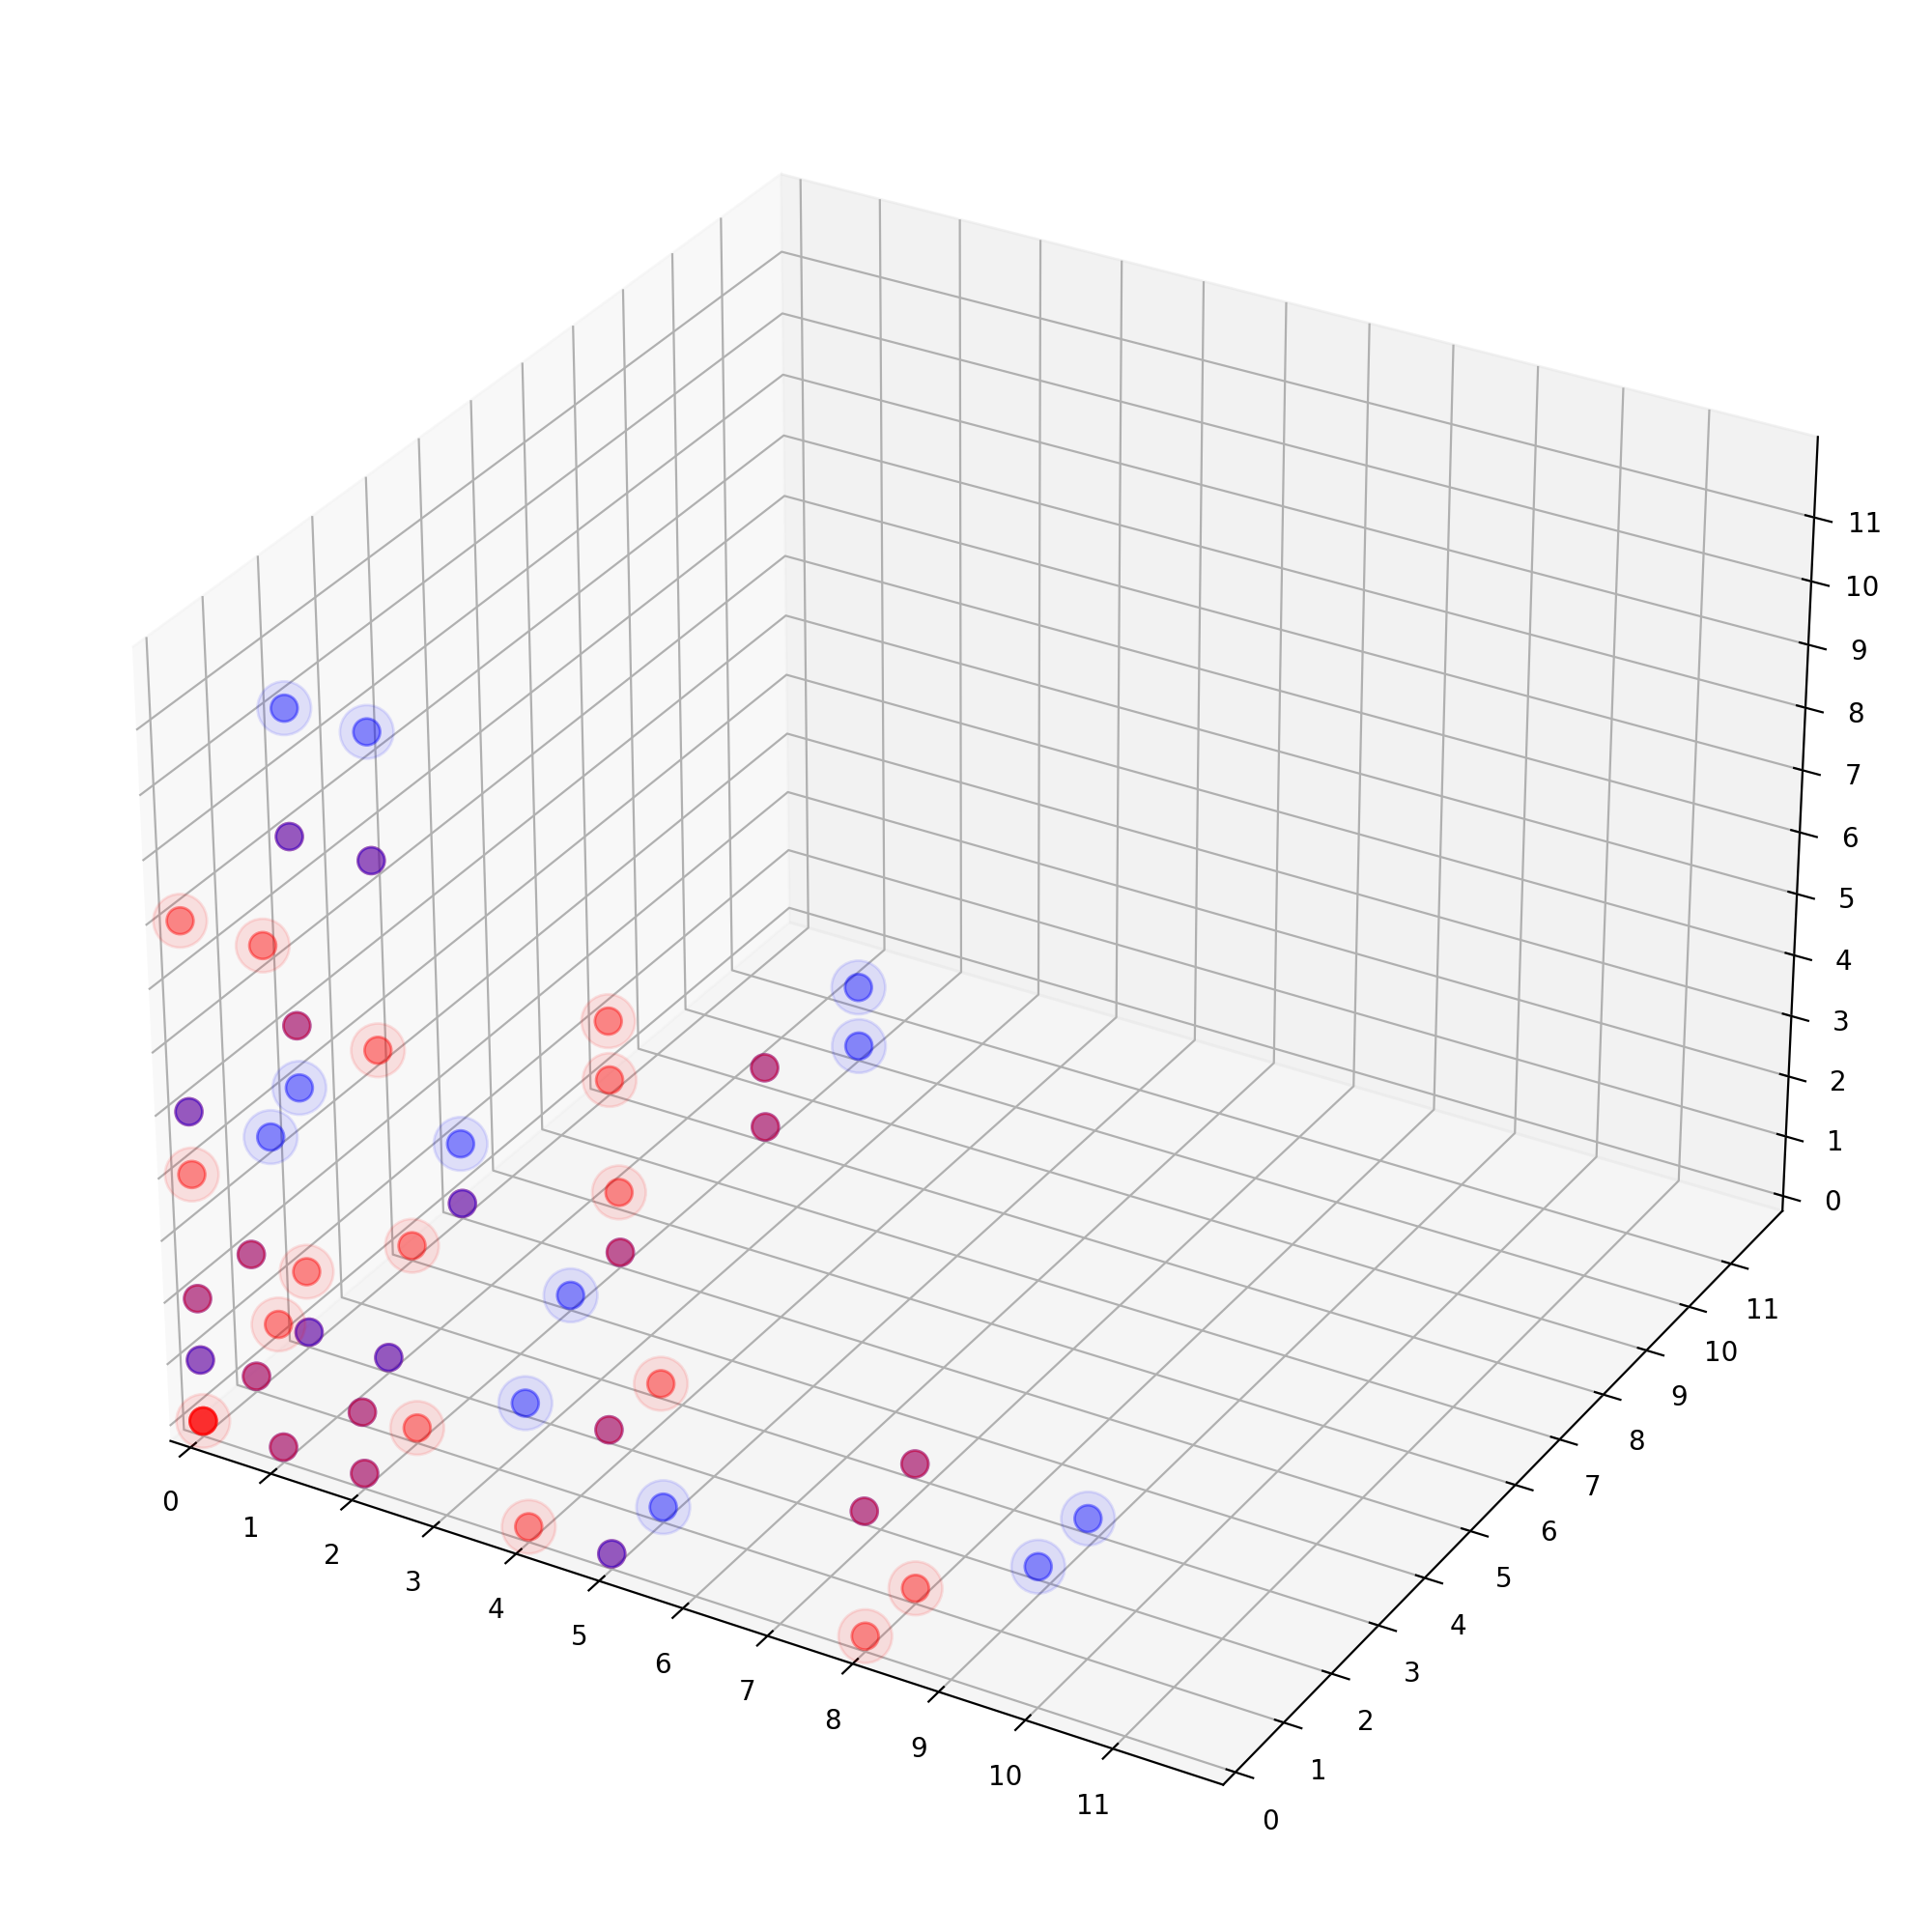

In [536]:
#failed attempt to improve Pan's initial aggregation technique
#   to compute @Nx2N MM w/ 8/3*N^3+18*N^2+O(N) multiplications
#   (the better algorithm by Laderman, Pan, and Sha uses a very different technique
#       to get rid of the intermediate terms in the tensor evaluation)
def calc_agg_results(aggs):
    targets=[np.zeros((2,)*6) for i in range(3)]
    unwanted=[np.zeros((2,)*6) for i in range(3)]
    for a in aggs:
        for i in range(3):
            targets[i]+=oprod(a[i])
            unwanted[i]+=oprod([a[(i+c)%3][c] for c in range(3)])
#     for a in range(len(aggs)):
#         print(a)
#         print(np.array(aggs[a]))
    print('TARGET')
    for i in range(3):
        print(['ijjkki','jkkiij','kiijjk'][i])
        if np.array_equal(targets[i],mmT(2)):
            print('---')
        else:
            print('!!!')
            print(compress(targets[i]))
    print('UNWANTED')
    for i in range(3):
        print(['ijkijk','jkijki','kijkij'][i])
        if np.array_equal(unwanted[i],np.zeros(unwanted[i].shape)):
            print('---')
        else:
            print('!!!')
            print(compress(unwanted[i]))
'''matrix notation of Pan's aggregation method
aggregating 24 terms with 8 aggregate products
every aggregate product is of the form (IJ(...),JK(...),KI(...))*(JK(...),KI(...),IJ(...)),(KI(...),IJ(...),JK(...))
each function IJ(), JK(), KI() takes in a 2x2 matrix
    and outputs a linear combo of terms only depending on (i,j), (j,k), (k,i) respectively
ex. IJ([[a,b],[c,d]]) outputs the terms a*E(i,j)+b*E(i,j+N)+c*E(i+N,j)+d*E(i+N,j+N)
same for JK(), KI() but (i,j) are replaced with (j,k) and (k,i) respectively
the primary goal is so all unacceptable terms are cancelled out
'''
E=lambda i,j:np.array([[1 if r==i and c==j else 0 for c in range(2)] for r in range(2)])
decomp=[(E(i,j),E(j,k),E(k,i)) for i in range(2) for j in range(2) for k in range(2)]
coefm=lambda coeffs,mats:[coeffs[i]*mats[i] for i in range(len(coeffs))]
augment=lambda m:[m,[m[1],m[2],m[0]],[m[2],m[0],m[1]]]
aggs=[
    # original
#     [decomp[0]]*3,
#     [coefm([-1,1,-1],decomp[1]),decomp[4],decomp[2]],
#     [decomp[2],coefm([-1,1,-1],decomp[1]),decomp[4]],
#     [decomp[4],decomp[2],coefm([-1,1,-1],decomp[1])],
#     [decomp[7]]*3,
#     [coefm([-1,1,-1],decomp[6]),decomp[3],decomp[5]],
#     [decomp[5],coefm([-1,1,-1],decomp[6]),decomp[3]],
#     [decomp[3],decomp[5],coefm([-1,1,-1],decomp[6])],
    # a bit more symmatric
    [decomp[0]]*3,
    [decomp[7]]*3,
    *augment([coefm([-1,1,-1],decomp[1]),coefm([-1,-1,1],decomp[4]),coefm([1,-1,-1],decomp[2])]),
    *augment([coefm([-1,1,-1],decomp[6]),coefm([-1,-1,1],decomp[3]),coefm([1,-1,-1],decomp[5])]),
#     *augment([coefm([-1,-1,1],decomp[1]),coefm([1,-1,-1],decomp[4]),coefm([-1,1,-1],decomp[2])]),
#     *augment([coefm([-1,-1,1],decomp[6]),coefm([1,-1,-1],decomp[3]),coefm([-1,1,-1],decomp[5])]),
#     [coefm([-1,1,-1],decomp[1]),coefm([-1,-1,1],decomp[4]),coefm([1,-1,-1],decomp[2])],
#     [coefm([1,-1,-1],decomp[2]),coefm([-1,1,-1],decomp[1]),coefm([-1,-1,1],decomp[4])],
#     [coefm([1,1,1],decomp[4]),coefm([-1,-1,1],decomp[2]),coefm([-1,1,-1],decomp[1])],
#     [coefm([-1,1,-1],decomp[6]),coefm([-1,-1,1],decomp[3]),coefm([1,-1,-1],decomp[5])],
#     [coefm([1,-1,-1],decomp[5]),coefm([-1,1,-1],decomp[6]),coefm([-1,-1,1],decomp[3])],
#     [coefm([1,1,1],decomp[3]),coefm([-1,-1,1],decomp[5]),coefm([-1,1,-1],decomp[6])],
]
calc_agg_results(aggs)
def shift(l,s):
    return [l[(i+s)%len(l)] for i in range(len(l))]
ret=0
for a in aggs[:]:
    for i in range(3):
        for j in range(3):
            for k in range(3):
                if (
                    (i==0 and j==2)
                    or
                    (j==2 and k==1)
                    or (k==1 and i==0)
                   ) and not(i==j and j==k) and not(j==(i+1)%3 and k==(i+2)%3):
                    ma=np.array([[a[r][c] if r==[i,j,k][c] else np.zeros((2,2)) for c in range(3)] for r in range(3)])
                    ma=[np.concatenate(tuple(shift(ma[:,c],-c))) for c in range(3)]
                    ret+=oprod(ma)
ret=compress(ret)
for i in range(12):
    for j in range(12):
        for k in range(12):
            if (not((i<2 and j<4) or (j<2 and k<4) or (k<2 and i<4))
                or ((i,j,k) in set([
                    #(0,2,1),(1,0,2),(2,1,0)
                    (1,2,3),(2,3,1),(3,1,2)
                ]))):
                ret[i][j][k]=0
decomp=[
    #gets everything right except for (0,0,0): coeff 3 instead of 1
    *augment(([1,1,0,0,0,0,0,0,0,0,0,0],[1,0,-1,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,-1,0,0,1,0,0,0])),
    *augment(([1,0,0,0,0,0,0,0,0,0,0,0],[1,0,-1,0,0,0,0,0,0,0,0,0],[0,-1,0,0,1,1,0,0,0,0,0,0])),
    *augment(([1,1,0,0,0,0,0,0,0,0,0,0],[0,0,-1,0,0,0,0,0,0,0,0,0],[-1,0,0,0,0,0,0,0,-1,0,1,0])),
]
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
ax.set_xlim([0,12])
ax.set_ylim([0,12])
ax.set_zlim([0,12])
ax.set_xticks(range(12))
ax.set_yticks(range(12))
ax.set_zticks(range(12))
if 0==0:
    plotT(ax,ret,ptsize=400,alpha=0.1)
    for d in decomp:
        plotT(ax,oprod(d),alpha=0.4)
else:
    plotT(ax,ret-sumdecomp(decomp))
plt.tight_layout()